# scMeMo implementation scratch notebook

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [10]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

In [11]:
data_path = '/data/parameter_estimation/interferon_data/20200412/'
# data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/parameter_estimation_paper/interferon_04_25_2020/'

### Perform some basic filtering

In [12]:
def simplify_name(name):
    return name.split('.')[0]

In [13]:
adata = sc.read(data_path + 'interferon.h5ad')
#adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [14]:
#adata = sc.read(data_path + 'interferon.h5ad')
adata.obs['n_counts'] = adata.X.sum(axis=1)

adata.var['n_max'] = adata.X.max(axis=0).toarray()[0]
adata.var['n_cell'] = (adata.X > 0).sum(axis=0).A1
#adata.var['unique_count'] = num_unique.values

# Filter criteria
adata = adata[:, adata.var['n_max'] > 20].copy()




In [15]:
adata.obs.cell.value_counts()

CD4 T cells          12033
CD14+ Monocytes      6447 
B cells              2880 
CD8 T cells          2634 
NK cells             2330 
FCGR3A+ Monocytes    1914 
Dendritic cells      472  
Megakaryocytes       346  
nan                  9    
Name: cell, dtype: int64

In [16]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

In [17]:
adata.obs.head(5)

,tsne1,tsne2,ind,stim,cluster,cell,multiplets,n_counts,cell_type
index,,,,,,,,,
AAACATACAATGCC-1,-4.277833,-19.294709,107,ctrl,5,CD4 T cells,doublet,2191.0,CD4 T cells - ctrl
AAACATACATTTCC-1,-27.640373,14.966629,1016,ctrl,9,CD14+ Monocytes,singlet,3018.0,CD14+ Monocytes - ctrl
AAACATACCAGAAA-1,-27.493646,28.924885,1256,ctrl,9,CD14+ Monocytes,singlet,2481.0,CD14+ Monocytes - ctrl
AAACATACCAGCTA-1,-28.132584,24.925484,1256,ctrl,9,CD14+ Monocytes,doublet,3157.0,CD14+ Monocytes - ctrl
AAACATACCATGCA-1,-10.468194,-5.984389,1488,ctrl,3,CD4 T cells,singlet,703.0,CD4 T cells - ctrl


In [18]:
sc.pl.tsne(adata, color='cell_type')

... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


In [19]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 365


### TFKO_140 Dataset sanity check

### Qualitatively assess estimation of q_sq in the interferon data

In [108]:
imp.reload(utils)
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=adata,
    n_umis_column='n_counts',
    covariate_label='stim',
    replicate_label='ind',
    batch_label=None,
    subsection_label='cell',
    num_permute=10000,
    covariate_converter={'ctrl':0, 'stim':1},
    q=.07)

estimator.compute_observed_moments(verbose=False)
estimator.estimate_q_sq(frac=0.3, verbose=True)
estimator.estimate_1d_parameters()

x_obs = np.log(estimator.observed_central_moments['all']['first'])
y_obs = np.log(estimator.observed_central_moments['all']['second'])

x_est = np.log(estimator.estimated_central_moments['all']['first'])
y_est = np.log(estimator.estimated_central_moments['all']['second'])


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )
E[q^2] falls in [0.00490, 0.00667941], with the current estimate of 0.00665600


In [109]:
%matplotlib inline

Text(0, 0.5, 'log( estimated cv )')

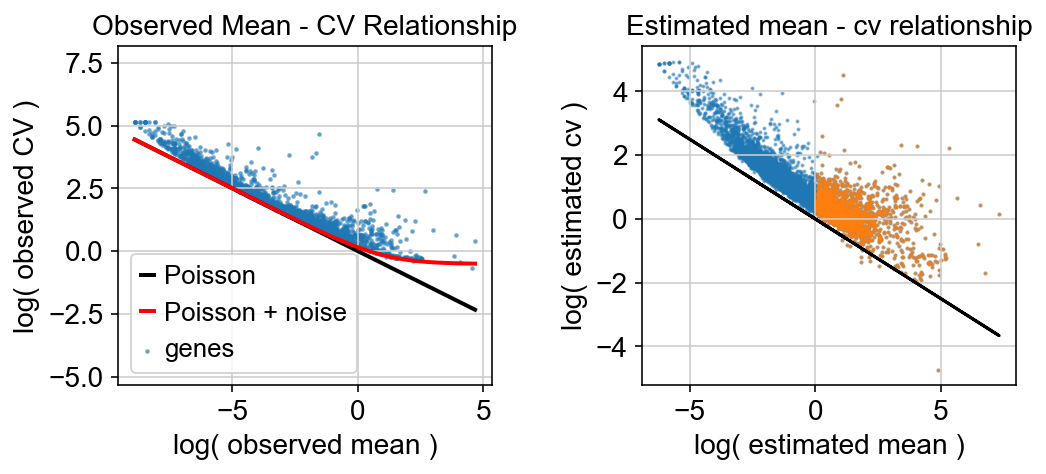

In [111]:
plt.figure(figsize=(8, 3));
plt.subplots_adjust(wspace=0.4)
plt.subplot(1, 2, 1)
estimator.plot_cv_mean_curve('all', estimated=False, plot_noise=True)
plt.subplot(1, 2, 2)
plt.scatter(x_est, y_est/2-x_est, s=1, alpha=0.5)
plt.scatter(x_est[estimator.k_largest_indices], y_est[estimator.k_largest_indices]/2-x_est[estimator.k_largest_indices], s=1, alpha=0.5)
plt.plot(x_est, -x_est/2, color='k')
plt.title('Estimated mean - cv relationship')
plt.xlabel('log( estimated mean )')
plt.ylabel('log( estimated cv )')

### Scratch

In [211]:
imp.reload(utils)
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=adata,
    n_umis_column='n_counts',
    covariate_label='stim',
    replicate_label='ind',
    batch_label=None,
    subsection_label='cell',
    num_permute=10000,
    covariate_converter={'ctrl':0, 'stim':1},
    q=.07)
estimator.compute_observed_moments(verbose=False)
estimator.q_sq = 0.00665600

In [212]:
estimator.setup_hypothesis_testing(subsections=['CD4 T cells'])


In [214]:
adata.shape

(29065, 365)

In [213]:
%%time
estimator.estimate_1d_parameters()
estimator.compute_effect_sizes_1d()
estimator.compute_confidence_intervals_1d()

CPU times: user 3min 4s, sys: 20.7 s, total: 3min 25s
Wall time: 1min 45s


In [205]:
gene_list_1, gene_list_2 = ['ISG15', 'OAS1'], ['IFI6', 'IFIT1', 'STAT1']
estimator.estimate_2d_parameters(gene_list_1, gene_list_2)
estimator.compute_effect_sizes_2d(gene_list_1, gene_list_2)
estimator.compute_confidence_intervals_2d(gene_list_1, gene_list_2)

In [207]:
gene_idx_1 = estimator._get_gene_idxs(gene_list_1)
gene_idx_2 = estimator._get_gene_idxs(gene_list_2)
estimator.hypothesis_test_result['CD4 T cells']['dc_pval'][gene_idx_1[:, np.newaxis], gene_idx_2].todense()

matrix([[8.9991000e-03, 1.0680249e-05, 4.9034934e-06],
        [7.9992004e-03, 2.9319018e-04, 2.7997200e-03]], dtype=float32)

In [198]:
gene_idx_1 = estimator._get_gene_idxs(gene_list_1)
gene_idx_2 = estimator._get_gene_idxs(gene_list_2)

In [181]:
temp = estimator.parameters['sg^ctrl^107^default_batch^CD4 T cells']['corr']#[gene_idx_1, :][:, gene_idx_2]#.toarray()

In [184]:
temp[gene_idx_1[:, np.newaxis], gene_idx_2].toarray()

array([[-0.18409139, -0.10855811],
       [ 0.18352777, -0.05938095],
       [-0.14708965,  1.        ]], dtype=float32)

In [169]:
temp.ravel()

array([-0.18409139, -0.10855811,  0.18352777, -0.05938095, -0.14708965,
        1.        ], dtype=float32)

In [171]:
temp.reshape(3, 2)

array([[-0.18409139, -0.10855811],
       [ 0.18352777, -0.05938095],
       [-0.14708965,  1.        ]], dtype=float32)